In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import spacy
import en_core_web_md
import random as rnd
import pandas as pd
import pickle as pkl
import bcolz
import numpy as np
import pprint
import matplotlib
import matplotlib.pyplot as plt
import traceback
import datetime
import os
import logging
import json
import re
import hashlib

from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler

In [3]:
nlp = en_core_web_md.load()

def parse(token_list):
    
    doc = nlp.tokenizer.tokens_from_list(token_list)
    for name, proc in nlp.pipeline:      
        doc.is_parsed=False
        doc=proc(doc)
        doc.is_parsed=True
        
    return doc

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [4]:
fold_lens = [37, 57, 63, 57, 52, 39, 31, 62, 52, 62]
with open("/proj/zimmermann/ncar/Data/combined_pretrain.pkl", "rb") as f:
    combined_coref = pkl.load(f)
with open("/proj/zimmermann/ncar/Data/combined_train.pkl", "rb") as f:
    combined = pkl.load(f)
    num_folds=10
    folds=[[] for _ in range(num_folds)]
    for sample in combined[::]:
        source = sample[-1]
        folds[int(hashlib.sha256((source+"c").encode('utf-8')).hexdigest(), 16) % num_folds].append(sample)
    combined_folds = [sample for fold in folds for sample in fold]
with open("/proj/zimmermann/ncar/Data/p2i.pkl", "rb") as f:
    p2i = pkl.load(f)
    i2p = {i:p for p,i in p2i.items()}
with open("/proj/zimmermann/ncar/Data/w2i.pkl", "rb") as f:
    w2i = pkl.load(f)
    i2w = {i:w for w,i in w2i.items()}
    

In [5]:
font = {'family' : 'STIXGeneral',
        'weight' : 'normal',
        'size'   : 16}

green = "xkcd:grass green" # "#3f9b0b" #
light_green = "xkcd:boring green"
red = "xkcd:tomato red" # "#ec2d01" #
orange = "xkcd:amber" # '#ffa62b' #
light_orange = "xkcd:apricot"
blue = "xkcd:water blue" # "#0e87cc" #
black = "black"

matplotlib.rc('font', **font)    

import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

Full
size	min	max
1	0.271484375	0.26881938936268307
2	0.271484375	0.26881938936268307
4	0.271484375	0.26881938936268307
8	0.271484375	0.26881938936268307
16	0.28515625	0.27922201805903
32	0.248046875	0.24576493880398806
64	0.3046875	0.3022086686772595
128	0.259765625	0.2700180735409938
256	0.263671875	0.266401258718746
449	0.27734375	0.27638550834645914

Full
size	min	max
1	0.271484375	0.26881938936268307
2	0.271484375	0.26881938936268307
4	0.271484375	0.26881938936268307
8	0.271484375	0.26881938936268307
16	0.287109375	0.2874203846190264
32	0.2890625	0.2860180274866183
64	0.275390625	0.2775269789276581
128	0.30859375	0.3055699713594451
256	0.318359375	0.31299425883466625
449	0.3359375	0.3322272117263628
Train - Cats
size	min	max
1	0.052734375	0.05122148725714091
2	0.060546875	0.06469274924283412
4	0.03125	0.03509752126050938
8	0.068359375	0.06597983457066649
16	0.15625	0.16034954150404068
32	0.220703125	0.2264627152572823
64	0.271484375	0.26942774553131094
128	0.25390625	0.25609623644

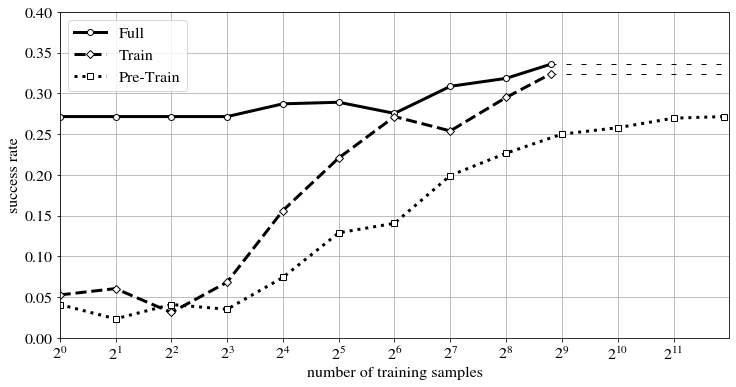

In [359]:
fig, ax = plt.subplots(1, figsize=(12, 6))

with open("/proj/zimmermann/ncar/Data/91_split_results.pkl", "rb") as f:
    split_results = pkl.load(f)
    x = [] 
    y_min = []
    y_max = []
    print("Full")
    print(f"size\tmin\tmax")
    for size,results in split_results.items():
        value = results["Full Sys."]
        max_results = []
        for f_i in range(len(fold_lens)):
            fl1 = sum(fold_lens[:f_i])
            fl2 = sum(fold_lens[:f_i+1])

            max_results.append(sum(value[fl1:fl2])/fold_lens[f_i])
        print(f"{size}\t{sum(value)/len(value)}\t{sum(max_results)/len(max_results)}")
        x.append(size)
        y_min.append(sum(value)/len(value))
        y_max.append(sum(max_results)/len(max_results))

        

###### FINAL ######
#plt.plot([x[-1],3825], [y_min[-1],y_min[-1]], "--",color="xkcd:grey", linewidth=1, label='_nolegend_', dashes=(5, 10))
#plt.plot(x,y_min,"o-",color="xkcd:grey",linewidth=3,markerfacecolor="white", label='_nolegend_')
######
plt.yticks(np.arange(0, 1.01, 0.05))
ax.set_xscale('log',basex=2)
plt.xlim([1,4096])
plt.ylim([0, 0.4])
plt.xticks([2**x for x in range(12)])
print()

with open("/proj/zimmermann/ncar/Data/94_split_results.pkl", "rb") as f:
    split_results = pkl.load(f)
    x = [] 
    y_min = []
    y_max = []
    print("Full")
    print(f"size\tmin\tmax")
    for size,results in split_results.items():
        value = results["Full Sys."]
        max_results = []
        for f_i in range(len(fold_lens)):
            fl1 = sum(fold_lens[:f_i])
            fl2 = sum(fold_lens[:f_i+1])

            max_results.append(sum(value[fl1:fl2])/fold_lens[f_i])
        print(f"{size}\t{sum(value)/len(value)}\t{sum(max_results)/len(max_results)}")
        x.append(size)
        y_min.append(sum(value)/len(value))
        y_max.append(sum(max_results)/len(max_results))

        

###### FINAL ######
plt.plot([x[-1],3825], [y_min[-1],y_min[-1]], "--",color="xkcd:black", linewidth=1, label='_nolegend_', dashes=(5, 10))
plt.plot(x,y_min,"o-",color="xkcd:black",linewidth=3,markerfacecolor="white")
######

with open("/proj/zimmermann/ncar/Data/90_split_train_results.pkl", "rb") as f:
    split_train_results = pkl.load(f)
    x = [] 
    y_min = []
    y_max = []
    
    print("Train - Cats")
    print("size\tmin\tmax")
    for size,t_results in split_train_results.items():
        value = t_results["Train"]
        max_results = []
        for f_i in range(len(fold_lens)):
            fl1 = sum(fold_lens[:f_i])
            fl2 = sum(fold_lens[:f_i+1])

            max_results.append(sum(value[fl1:fl2])/fold_lens[f_i])
        print(f"{size}\t{sum(value)/len(value)}\t{sum(max_results)/len(max_results)}")
        x.append(size)
        y_min.append(sum(value)/len(value))
        y_max.append(sum(max_results)/len(max_results))
        
#plt.plot(x,y_max,"o-",color=light_orange,linewidth=3)
######
plt.plot([x[-1],3825], [y_min[-1],y_min[-1]], "--",color="xkcd:black", linewidth=1, label='_nolegend_', dashes=(5, 10))
plt.plot(x,y_min,"D--",color="xkcd:black",linewidth=3,markerfacecolor="white")
######
print()

#### FINAL ####
with open("/proj/zimmermann/ncar/Data/91_split_coref_results.pkl", "rb") as f:
    split_coref_results = pkl.load(f)
    x = [] 
    y_min = []
    y_max = []
    
    print("Pre-Train")
    print("size\tmin\tmax")
    for size,c_results in split_coref_results.items():
        value = c_results["Pre-Train"]
        max_results = []
        for f_i in range(len(fold_lens)):
            fl1 = sum(fold_lens[:f_i])
            fl2 = sum(fold_lens[:f_i+1])

            max_results.append(sum(value[fl1:fl2])/fold_lens[f_i])
        print(f"{size}\t{sum(value)/len(value)}\t{sum(max_results)/len(max_results)}")
        x.append(size)
        y_min.append(sum(value)/len(value))
        y_max.append(sum(max_results)/len(max_results))
        
#plt.plot(x,y_max,"o-",color=light_orange,linewidth=3
#######
plt.plot([x[-1],3825], [y_min[-1],y_min[-1]], "--",color=black, linewidth=1, label='_nolegend_', dashes=(5, 10))
plt.plot(x,y_min,"s:",color=black,linewidth=3,markerfacecolor="white")
######


ax.grid()

plt.legend(["Full","Train",
            "Pre-Train"])
#plt.legend(["Full", " w/o Spans/Distance","Train", " w/o Spans/Distance", "Pre-Train"," w/o Spans/Distance"])
ax.set(xlabel='number of training samples', ylabel='success rate')

f_res = split_results
pt_res = split_coref_results
t_res = split_train_results

all_res = []
for res in f_res.values():
    if sum(res['Full Sys.'])/512 > 0.23:
        all_res.append(res['Full Sys.'])
for res in pt_res.values():
    if sum(res['Pre-Train'])/512 > 0.23:
        all_res.append(res['Pre-Train'])
for res in t_res.values():
    if sum(res['Train'])/512 > 0.23:
        all_res.append(res['Train'])

b_res = t_res[449]['Train']
#b_res = f_res[449]['Full Sys.']
#all_res = [f_res[449]['Full Sys.'],t_res[449]['Pre-Train'],pt_res[3825]['Pre-Train']]

[37, 57, 63, 57, 52, 39, 31, 62, 52, 62]
ablation		min		max
w/o POS		0.298828125		0.2957133601445996
w/o Embeddings		0.271484375		0.2735968290722111
w/o Heads		0.279296875		0.28256917246730484
w/o Distance		0.3359375		0.33504527027447234
w/o Spans		0.3359375		0.3388434606176542
w/o Spans/Heads		0.248046875		0.24630990017237897
w/o Spans/Heads/Distance		0.26953125		0.2730066887537176
only Embeddings		0.22265625		0.22148370221375316
only POS		0.25		0.24858716997936012
w/o Spans/Distance		0.341796875		0.33891058683079056



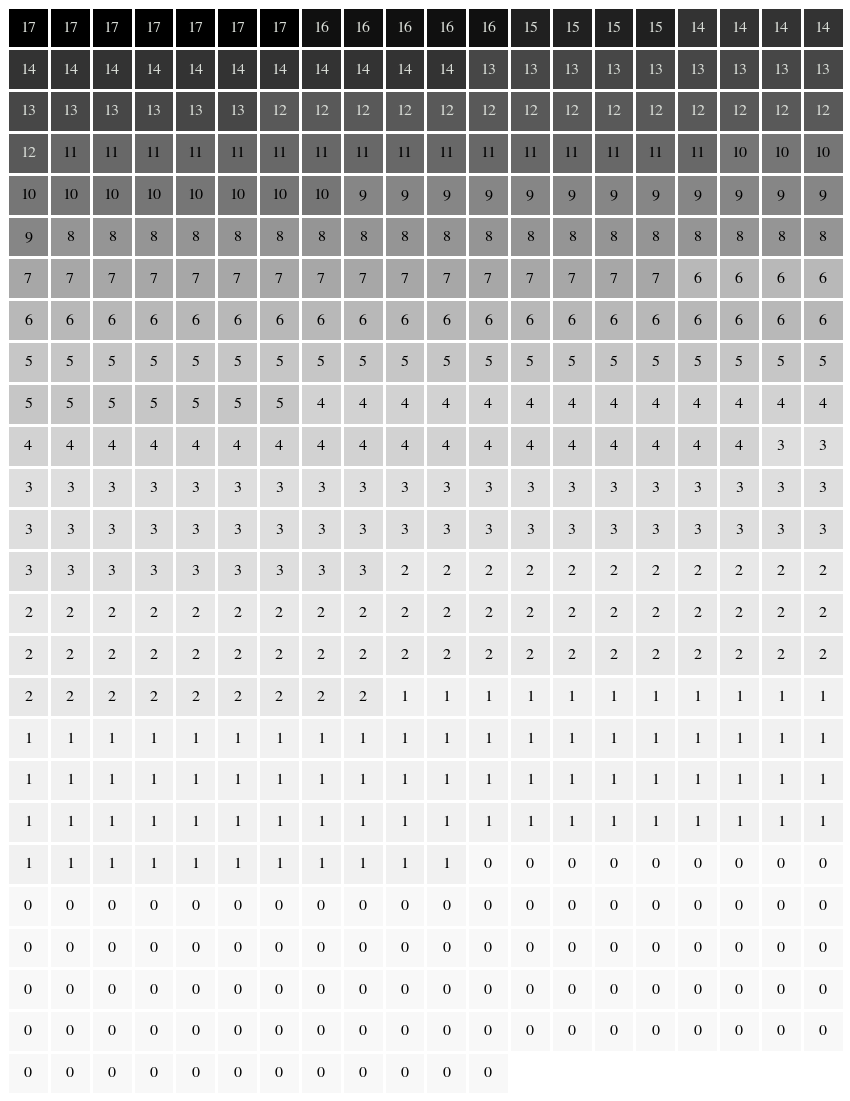

In [7]:
print(fold_lens)
with open("/proj/zimmermann/ncar/Data/02_ablation_results.pkl", "rb") as f:
    results = pkl.load(f)

    print(f"ablation\t\tmin\t\tmax")
    for size,results in results.items():
        value = results["Train"]
        max_results = []
        for f_i in range(len(fold_lens)):
            fl1 = sum(fold_lens[:f_i])
            fl2 = sum(fold_lens[:f_i+1])

            max_results.append(sum(value[fl1:fl2])/fold_lens[f_i])
        print(f"{size}\t\t{sum(value)/len(value)}\t\t{sum(max_results)/len(max_results)}")

print()

#all_res = [f_res[449]['Full Sys.'],t_res[449]['Train'],pt_res[3825]['Pre-Train']]

from matplotlib.patches import Rectangle
impossible = [95,131,96,294,505,475]

zip_res = zip(*all_res)

sum_res = []
for i,v in enumerate(zip_res):
    sum_res.append((sum(v),i))

numcols=20
col,row = [],[]
icol,irow = [],[]
idict = {}
for i,v in enumerate(sorted(sum_res,key=lambda x: (-x[0],x[1] in impossible,x[1]))):
    idict[v[1]] = (len(row),len(col))
    row.append(v[0])
    irow.append(v[1])
    #print(row)
    if i % numcols == numcols-1:
        col.append(row)
        icol.append(irow)
        row = []
        irow = []
if row:
    col.append(row+[-1]*(numcols-len(row)))
    icol.append(irow+[-1]*(numcols-len(irow)))
    
harvest = np.array(col)
iharvest = np.array(icol)
#print(col)
#harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
#                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
#                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
#                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
#                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
#                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
#                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])



fig, ax = plt.subplots(1, figsize=(25, 20))
im = ax.imshow(harvest, cmap="Greys")

numrows, numcols = harvest.shape

# We want to show all ticks...
#ax.set_xticks(np.arange(len(farmers)))
#ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
#ax.set_xticklabels(farmers)
#ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(numrows):
    for j in range(numcols):
        #text = ax.text(j, i, f"{iharvest[i, j]}\n{harvest[i, j]}\n{combined[iharvest[i, j]][2].count(2)}",#[-1].split('_')[0]}",
        #               ha="center", va="center", color="black")
        if harvest[i, j] == -1:        
            text = ax.text(j, i, f"{harvest[i, j]}",#\n{combined[iharvest[i, j]][-1].split('_')[0]}",
                       ha="center", va="center", color="white")
        elif harvest[i, j] > 11:        
            text = ax.text(j, i, f"{int(harvest[i, j])}",#\n{combined[iharvest[i, j]][-1].split('_')[0]}",
                       ha="center", va="center", color="xkcd:light grey")
        else:
            text = ax.text(j, i, f"{int(harvest[i, j])}",#\n{combined[iharvest[i, j]][-1].split('_')[0]}",
                       ha="center", va="center", color="black")       

if row:
    ax.add_patch(Rectangle((len(row)-.5, len(col)-1.5), numcols-len(row), 1, color='white', fill=True, lw=3))

for i,v in enumerate(combined_folds):
    ax.add_patch(Rectangle((idict[i][0]-.5, idict[i][1]-.5), 1, 1, color=(1, 1, 1, 1), fill=False, lw=3))
    
for i,v in enumerate(combined_folds):
    #print(sum(v[5]), end = ", ")
    if np.argmax(v[2]) < np.argmax(v[4]):
        pass
        #print(sum(v[5]))
        #ax.add_patch(Rectangle((idict[i][0]-.5, idict[i][1]-.5), 1, 1, color=black, fill=False, lw=3))
    if i in impossible:
        pass
        #print(sum(v[5]))
        #ax.add_patch(Rectangle((idict[i][0]-.5, idict[i][1]-.5), 1, 1, color=red, fill=False, lw=3))

    
plt.axis('off')
#fig.tight_layout()
plt.show()

In [8]:
with open("/proj/zimmermann/ncar/Data/00_split_coref_cats.pkl", "rb") as f:
    coref_cats = pkl.load(f)
with open("/proj/zimmermann/ncar/Data/03_split_train_cats.pkl", "rb") as f:
    w_cats = pkl.load(f)
with open("/proj/zimmermann/ncar/Data/03_split_train_cats.pkl", "rb") as f:
    wo_cats = pkl.load(f)
with open("/proj/zimmermann/ncar/Data/03_split_cats.pkl", "rb") as f:
    cats = pkl.load(f)
    
#with open("/proj/zimmermann/ncar/Data/00_split_coref_y_.pkl", "rb") as f:
    #coref_cats = pkl.load(f)    
    #for key in coref_cats.keys():
        #dataset = [y.item() for x in coref_cats[key]["Pre-Train"] for y in x]
        #cat_counter=0
        #for i,(y_,s) in enumerate(zip(dataset,combined_folds)):
            #if y_ > np.argmax(s[2]):
                #cat_counter += 1
        #coref_cats[key]["Pre-Train"] = cat_counter
#with open("/proj/zimmermann/ncar/Data/00_split_train_y_.pkl", "rb") as f:
#    w_cats = pkl.load(f)
#with open("/proj/zimmermann/ncar/Data/01_split_train_y_.pkl", "rb") as f:
#    wo_cats = pkl.load(f)
#with open("/proj/zimmermann/ncar/Data/00_split_y_.pkl", "rb") as f:
    #cats = pkl.load(f)       
    #for key in cats.keys():
        #dataset = [y.item() for x in cats[key]["Full Sys."] for y in x]
        #cat_counter=0
        #for i,(y_,s) in enumerate(zip(dataset,combined_folds)):
            #if y_ > np.argmax(s[2]):
                #cat_counter += 1
        #cats[key]["Full Sys."] = cat_counter

#print(coref_cats[3825]["Pre-Train"])
#print([y.item() for x in coref_cats[3825]["Pre-Train"] for y in x])
    
print(successes)
    
fig, ax = plt.subplots(1, figsize=(12, 6))


x,y = [],[]
for key, value in cats.items():
    x.append(key)
    y.append(sum(value['Full Sys.']))
plt.plot(x[:len(y)],y,"o-",color=black,linewidth=3,markerfacecolor="white", label="Full")

x,y = [],[]
for key, value in w_cats.items():
    x.append(key)
    y.append(sum(value['Train']))
plt.plot(x[:len(y)],list(y),"D--",color=black,linewidth=3,markerfacecolor="white", label="Train")

x,y = [],[]
for key, value in coref_cats.items():
    x.append(key)
    y.append(sum(value['Pre-Train']))
plt.plot(x,y,"s:",color=black,linewidth=3,markerfacecolor="white", label="Pre-Train")

plt.yticks(np.arange(0, 441, 50))
ax.set_xscale('log',basex=2)
plt.xticks(x)
plt.xlim([1,max(x)])
plt.ylim([0, max(y)+30])


plt.legend()

ax.set(xlabel='number of training samples', ylabel='number of non-head predictions')
ax.grid()

plt.show()

NameError: name 'successes' is not defined

In [372]:
with open("/proj/zimmermann/ncar/Data/94_split_y_.pkl", "rb") as f:
    b_y_ = pkl.load(f)[449]['Full Sys.']#['Train']
    b_y_ = [x.item() for y in b_y_ for x in y]
    
with open("/proj/zimmermann/ncar/Data/94_split_results.pkl", "rb") as f:
    b_res = pkl.load(f)[449]['Full Sys.']#['Train']
    
with open("/proj/zimmermann/ncar/Data/90_split_train_y_.pkl", "rb") as f:
    b_y_2 = pkl.load(f)[449]['Train']
    b_y_2 = [x.item() for y in b_y_2 for x in y]
    
with open("/proj/zimmermann/ncar/Data/91_split_coref_y_.pkl", "rb") as f:
    b_y_3 = pkl.load(f)[3825]['Pre-Train']
    b_y_3 = [x.item() for y in b_y_3 for x in y]

In [368]:
y_d = {}
y_p = {}
y_comp = {"JJR":[], "'more'":[], "'less'":[], "others":[]}
y_dist = {}

comp_adjs = ["other", "similar", "further", "seperate", "comparable", "added", "supplemental"
             "different", "additional", "extra", "supplementary"]
texts = []
POSs = []
d20 = 0
off_by = []
others_nt_count = 0
others_wsj_count = 0
others_count = 0
different_class = 0
subsets = {f"{h}{i}{j}":0 for h in range(2) for i in range(2) for j in range(2)}
del subsets["000"]
for sample in zip(combined_folds,b_res,b_y_,b_y_2,b_y_3):
    s,y_,P,Q,R = sample #P for Prediction
    d = s[-1].split("_")[0]
    if d in y_d:
        y_d[d].append(y_)
    else:
        y_d[d] = [y_]
        
    h = np.argmax(s[2])
    a = np.argmax(s[4])
    if h-P > 20:
        d20 += 1
        
    if P == Q == R:
        subsets["111"] += 1
    elif P == Q:
        subsets["110"] += 1
        subsets["001"] += 1
    elif P == R:
        subsets["101"] += 1
        subsets["010"] += 1
    elif Q == R:
        subsets["011"] += 1
        subsets["100"] += 1
    elif P!=Q and Q!=R and R!=P:
        subsets["100"] += 1
        subsets["010"] += 1
        subsets["001"] += 1
        
        
    if P != a:
        off_by.append(abs(a-P))
    if h-a in y_dist:
        y_dist[h-a].append(y_)
    else:
        y_dist[h-a] = [y_]
        
    p = [i2p[s_i] for s_i in s[-2]]
    y = np.argmax(s[4])
    #print(anaphora)
    if p[y] in y_p:
        y_p[p[y]].append(y_)
    else:
        y_p[p[y]] = [y_]
        
        
    t = [i2w[ii] if i != y else f"[{i2w[ii]}]"  for i,ii in enumerate(s[0])]
    
    if "party" in t and "extent" in t:
        print(s[2])
        print(s[1])
        print(p)
        print(" ".join(t), end="\n\n")
        
    if "others" in t:
        others_count += 1
        
    h_id = s[3][0][h]
    anaphora = [t_i for t_i,m_i in zip(t,s[3][0]) if m_i == h_id]
    texts.append((t,anaphora))
    POSs.append((p,p[y]))
    
    comp_adj_in = False
    for comp_adj in comp_adjs:
        if comp_adj in anaphora:
            comp_adj_in = True
            if comp_adj in y_comp:
                y_comp[comp_adj].append(y_)
            else:
                y_comp[comp_adj] = [y_]
            break
    if not comp_adj_in:
        if 'more' in anaphora:
            y_comp["'more'"].append(y_)
        elif 'others' in anaphora:
            y_comp["others"].append(y_)
            if d == "nt":
                others_nt_count +=1
            if d == "wsj":
                others_wsj_count +=1
        elif 'less' in anaphora:
            y_comp["'less'"].append(y_)
        else:
            y_comp["JJR"].append(y_)
print(np.mean(off_by)) #full: 10.234375 (13.47043701799486), train: 9.435546875 (13.49)
print(different_class)

[1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 3, 1, 1, 2, 1]
[0, 0, 0, 0, 0, 0, 0, 0.125, 0.14285714285714285, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0, 0.2, 0, 0.25, 0, 0, 0, 0.3333333333333333, 0, 0, 0, 0, 0.5, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]
['UH', '.', 'RB', ',', 'RB', ',', 'DT', 'NNPS', 'PRP', ',', 'VBG', 'DT', 'NNP', ',', 'VBD', 'IN', 'DT', 'NN', 'WRB', 'PRP', 'VBD', 'DT', 'NNP', 'NN', 'VBD', 'IN', 'DT', 'JJ', 'NN', 'IN', 'PRP', 'VBD', 'DT', 'JJ', 'NN', 'IN', 'JJ', 'NN', '.']
right . then , later , the westerners themselves , including the us , admitted that the reason why it won the kosovo war was to a large extent that [they] won the other party in public opinion .

11.980113636363637
0


{'000': 254, '001': 47, '010': 67, '011': 21, '100': 41, '101': 16, '110': 40, '111': 26}


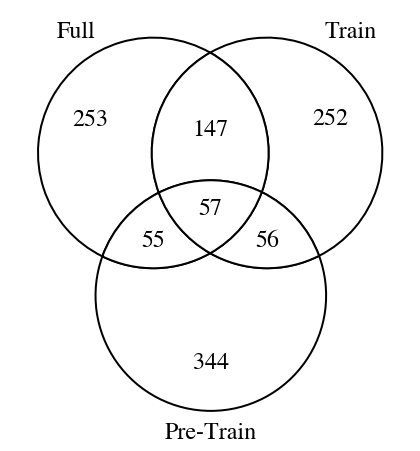

In [369]:
from matplotlib_venn import venn3_circles,venn3
#C = venn3_circles(subsets = (2, 2, 2, 2, 2, 2, 2))
print(sets)
fig, ax = plt.subplots(1, figsize=(8, 8))
#venn3(subsets = tuple(sets.values()), set_labels=("Full", "Train","Pre-Train"))
#subsets = (sets[(0,)],sets[(1,)],sets[(0,1)],sets[(2,)],sets[(0,2)],sets[(1,2)],sets[(0,1,2)])
v = venn3(subsets = subsets, set_labels=("Full", "Train","Pre-Train"))
for ss in subsets.keys():
    v.get_patch_by_id(ss).set_alpha(1.0)
    v.get_patch_by_id(ss).set_color("white")
    v.get_patch_by_id(ss).set_lw(2)
    v.get_patch_by_id(ss).set_edgecolor("black")
"""
plt.annotate('None\n', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(290,-239),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='xkcd:light grey', alpha=0.4,ls="--"),
             fontsize=20)

plt.annotate(str(512-sum(subsets.values())), xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(290,-240),
             ha='center', textcoords='offset points')
"""


for text in v.subset_labels:
    text.set_fontsize(24)
for text in v.set_labels:
    text.set_fontsize(24)


In [ ]:
fig, ax2 = plt.subplots(1, figsize=(12, 6))
ax1 = ax2.twinx()
successes = []
full_succs = []
failures = []
groups = []
lens = []
start,end = 15,52
sorted_dist = sorted(list(y_dist.items()), key=lambda x: -x[0])
for dist,y_ in sorted_dist:
    successes.append(sum(y_)/len(y_))
    full_succs.append(sum(y_))
    failures.append((len(y_)-sum(y_))/len(y_))
    groups.append(dist)
    lens.append(len(y_))
    print(f"{dist}:\t{sum(y_)/len(y_)}\t{len(y_)}")
    
    
successes = [sum(full_succs[:start])/sum(lens[:start])] + successes[start:end] + [sum(full_succs[end:])/sum(lens[end:])]
lens = [sum(lens[:start])] + lens[start:end] + [sum(lens[end:])]
groups = ['> 38'] + [str(g) for g in groups[start:end]] + ['< 2']



#successes = dict(zip(groups,successes))
#successes = [0 if i not in groups else successes[i] for i in reversed(range(min(groups),max(groups)+1))]
#failures = dict(zip(groups,failures))
#failures = [0 if i not in groups else failures[i] for i in reversed(range(min(groups),max(groups)+1))]
print(len(groups), len(failures))
#ind = np.arange(len(groups))
width = 0.5       # the width of the bars: can also be len(x) sequence

p2 = ax2.bar(groups,lens, width, color="xkcd:light grey", edgecolor="xkcd:grey")
p1 = ax1.plot(groups,successes, width, color=black, linewidth=2)
#p2 = plt.bar(groups,failures, width,
#             bottom=successes, color='red')
ax1.set_ylabel('success rate')
ax2.set_ylabel('number of samples')
ax2.set_xlabel('distance between true antecedent and anaphora')
#plt.title('Scores by group and gender')
ax2.set_xticklabels(groups,rotation=90)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_yticks(np.arange(0, 50, 5))
plt.xlim(-1,39)
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 50)
plt.legend((p1[0], p2[0]), ('success rate', 'number of samples'), loc="upper left")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")

plt.show()

PRP:	0.15211970074812967	802
NNS:	0.08597807270628967	1733
NN:	0.053514092044238314	2803
NNP:	0.04448871181938911	1506
WP:	0.06299212598425197	127
NNPS:	0.109375	64
JJ:	0.002992220227408737	1671
CD:	0.009345794392523364	428
{'PRP', 'NNPS', 'NNS', 'CD', 'NNP', 'JJ', 'WP', 'NN'}


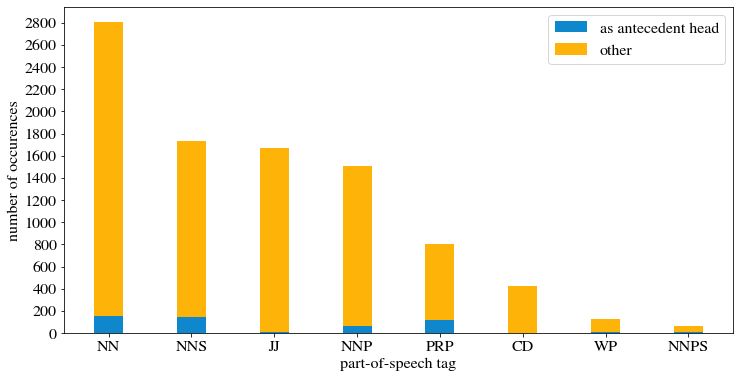

In [26]:
fig, ax = plt.subplots(1, figsize=(12, 6))

successes_ = []
failures_ = []
groups_ = []
for p,_ in sorted(y_p.items(), key=lambda p: -sum(p[1])):
    succ_p = 0
    fail_p = 0
    for sent_p,p_y in POSs:
        if p_y == p:
            succ_p += 1
            fail_p += sent_p.count(p)-1
        else:
            fail_p += sent_p.count(p)
    successes_.append(succ_p)
    failures_.append(fail_p)
    groups_.append(p)
    print(f"{p}:\t{succ_p/(fail_p+succ_p)}\t{fail_p+succ_p}")
    
successes = []
failures = []
groups = []
for succ, fail, group in sorted(zip(successes_,failures_,groups_), key=lambda x: -(x[0]+x[1])):
    successes.append(succ)
    failures.append(fail)
    groups.append(group)
    
print(set(y_p.keys()))
ind = np.arange(len(groups))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, successes, width, color=blue)
p2 = plt.bar(ind, failures, width,
             bottom=successes, color=orange)

plt.ylabel('number of occurences')
plt.xlabel('part-of-speech tag')
#plt.title('Scores by group and gender')
plt.xticks(ind, groups, rotation=0)
plt.yticks(np.arange(0, 3000, 200))
plt.legend((p1[0], p2[0]), ('as antecedent head', 'other'))

plt.show()

NN:	0.19333333333333333	150
NNS:	0.3087248322147651	149
PRP:	0.6147540983606558	122
NNP:	0.208955223880597	67
WP:	0.5	8
NNPS:	0.42857142857142855	7
JJ:	0.2	5
CD:	0.0	4


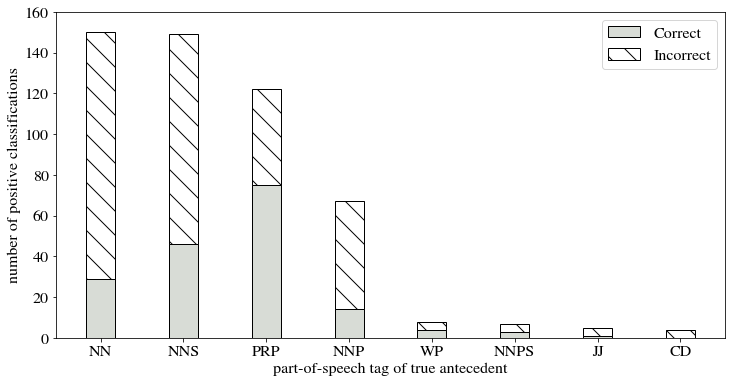

In [373]:
fig, ax = plt.subplots(1, figsize=(12, 6))

successes = []
failures = []
groups = []
sorted_pos = sorted(list(y_p.items()), key=lambda x: -len(x[1]))
for p,y_ in sorted_pos:
    successes.append(sum(y_))
    failures.append(len(y_)-sum(y_))
    groups.append(p)
    print(f"{p}:\t{sum(y_)/len(y_)}\t{len(y_)}")

ind = np.arange(len(sorted_pos))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

patterns = [ "|" , "\\" , "/" , "+" , "-", ".", "*","x", "o", "O" ]
p1 = plt.bar(ind, successes, width,edgecolor='black', color="xkcd:light grey")
p2 = plt.bar(ind, failures, width,
             bottom=successes,edgecolor='black', color="xkcd:white", hatch=patterns[1])

plt.ylabel('number of positive classifications')
plt.xlabel('part-of-speech tag of true antecedent')
#plt.title('Scores by group and gender')
plt.xticks(ind, groups, rotation=0)
plt.yticks(np.arange(0, 161, 20))
plt.legend((p1[0], p2[0]), ('Correct', 'Incorrect'))

plt.show()

wsj:	0.2122905027932961	179
nt:	0.5434782608695652	138
ectb:	0.3333333333333333	51
eng:	0.15151515151515152	33
cnn:	0.35714285714285715	28
a2e:	0.35	20
chtb:	0.21428571428571427	14
voa:	0.1	10
pri:	0.1111111111111111	9
ch:	0.42857142857142855	7
msnbc:	0.5714285714285714	7
cctv:	0.3333333333333333	6
c2e:	0.6	5
nbc:	0.5	4
mnb:	1.0	1


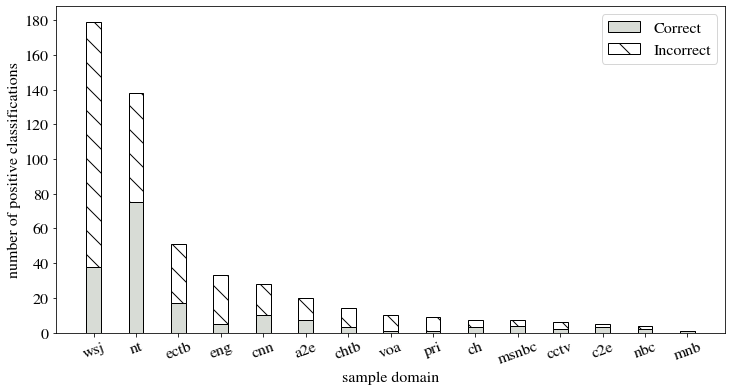

In [374]:

fig, ax = plt.subplots(1, figsize=(12, 6))

successes = []
failures = []
groups = []
sorted_domains = sorted(list(y_d.items()), key=lambda x: -len(x[1]))
for d,y_ in sorted_domains:
    successes.append(sum(y_))
    failures.append(len(y_)-sum(y_))
    groups.append(d)
    print(f"{d}:\t{sum(y_)/len(y_)}\t{len(y_)}")
ind = np.arange(len(sorted_domains))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

patterns = [ "|" , "\\" , "/" , "+" , "-", ".", "*","x", "o", "O" ]
p1 = plt.bar(ind, successes, width,edgecolor='black', color="xkcd:light grey")
p2 = plt.bar(ind, failures, width,
             bottom=successes,edgecolor='black', color="xkcd:white", hatch=patterns[1])

plt.ylabel('number of positive classifications')
plt.xlabel('sample domain')
#plt.title('Scores by group and gender')
plt.xticks(ind, groups, rotation=20)
plt.yticks(np.arange(0, 181, 20))
plt.legend((p1[0], p2[0]), ('Correct', 'Incorrect'))

plt.show()

other:	0.30275229357798167	218
others:	0.5273972602739726	146
JJR:	0.2857142857142857	56
'more':	0.19148936170212766	47
similar:	0.0	11
further:	0.09090909090909091	11
additional:	0.2	10
'less':	0.14285714285714285	7
comparable:	0.0	3
added:	0.0	2
extra:	0.0	1


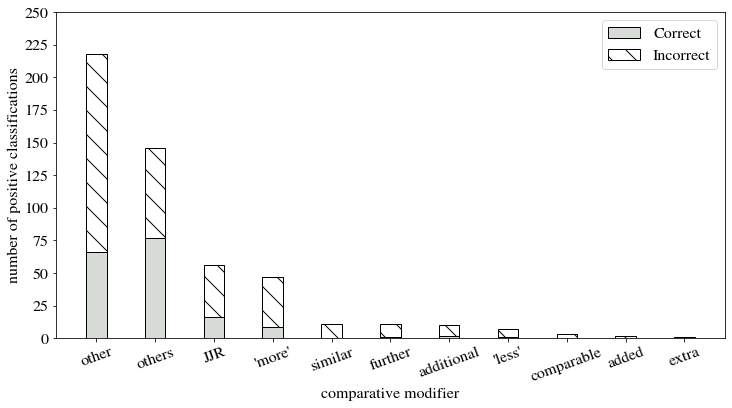

In [375]:
fig, ax = plt.subplots(1, figsize=(12, 6))

successes = []
failures = []
groups = []
sorted_comp = sorted(list(y_comp.items()), key=lambda x: -len(x[1]))
for comp,y_ in sorted_comp:
    successes.append(sum(y_))
    failures.append(len(y_)-sum(y_))
    groups.append(comp)
    print(f"{comp}:\t{sum(y_)/len(y_)}\t{len(y_)}")

ind = np.arange(len(sorted_comp))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

patterns = [ "|" , "\\" , "/" , "+" , "-", ".", "*","x", "o", "O" ]
p1 = plt.bar(ind, successes, width,edgecolor='black', color="xkcd:light grey")
p2 = plt.bar(ind, failures, width,
             bottom=successes,edgecolor='black', color="xkcd:white", hatch=patterns[1])

plt.ylabel('number of positive classifications')
plt.xlabel('comparative modifier')
#plt.title('Scores by group and gender')
plt.xticks(ind, groups, rotation=20)
plt.yticks(np.arange(0, 261, 25))
plt.legend((p1[0], p2[0]), ('Correct', 'Incorrect'))

plt.show()

In [398]:

with open("/proj/zimmermann/ncar/Data/04_split_y_.pkl", "rb") as f:
    DIST = pkl.load(f)[449]['Full Sys.']
    DIST = [x.item() for y in DIST for x in y]
with open("/proj/zimmermann/ncar/Data/94_split_y_.pkl", "rb") as f:
    NODIST = pkl.load(f)[449]['Full Sys.']
    NODIST = [x.item() for y in NODIST for x in y]
with open("/proj/zimmermann/ncar/Data/93_split_y_.pkl", "rb") as f:
    NODIST2 = pkl.load(f)[449]['Full Sys.']
    NODIST2 = [x.item() for y in NODIST2 for x in y]

pos_count = {}
d_D,d_N = [],[]
d_y = []
for sample in zip(combined_folds,DIST,NODIST,NODIST2):
    s,D,N,N2 = sample #P for Prediction
    d = s[-1].split("_")[0]
        
    h = np.argmax(s[2])
    a = np.argmax(s[4])
    
    y = np.argmax(s[4])
    
    if D != y:
        d_D.append(h-D)
    if N != y:
        d_N.append(h-N)
    d_y.append(h-y)
    
        
    t = []
    p = [i2p[s_i] for s_i in s[-2]]
    
    if p[D] in pos_count:
        pos_count[p[D]] += 1
    else:
        pos_count[p[D]] = 1
        
    if p[N] in pos_count:
        pos_count[p[N]] -= 1
    else:
        pos_count[p[N]] = -1
    
    for i,tok in enumerate(s[0]):
        word = i2w[tok]
        if i == y:
            word = "["+word+"]"
        if i == D:
            word = "{"+word+"}"
        if i == N:
            word = "("+word+")"
        if i == N2:
            word = "("+word+")"
        t.append(word)
    
    if D!=N and D!=N2:
        print(" ".join(t), "\n")
        
print(pos_count)
print(np.mean(d_D), np.mean(d_N), np.mean(d_y), np.median(d_y))

in any (case) , teng 's copious [fieldwork] is not {something} (you) can afford to ignore . among other projects , teng 's work with the thao -lrb- also known as the shao or sao -rrb- , a tiny aboriginal tribe living in the vicinity of sun moon lake , looms particularly important in the wake of the chichi earthquake , for the temblor has dealt a heavy blow to a community that now has only 282 members left . 

when the {people} heard about jesus being raised from death , some of (([them])) laughed . but others said , `` we will hear more about this from you later . '' 

the sort of regulation airlines hate . but if delays continue to grow , {[it]} could force similar moves for other (airports) in a desperate effort to ease the (gridlock) with no other ready solution in sight . 

worst job {you} ever had . high - profile ((people)) who are taking it on the [arthur] and heading for other places . 

meanwhile , supporters of the dellums two - party consent bill say it is needed because of 

In [378]:
b = 10**4
with open("/proj/zimmermann/ncar/Data/00_split_coref_results.pkl", "rb") as f:
    res = pkl.load(f)[3825]
    RECENCY = res['Recency']
    RANDOM = res['Random']
    HEADMATCH = res['Head Match']
with open("/proj/zimmermann/ncar/Data/94_split_results.pkl", "rb") as f:
    FULL = pkl.load(f)[449]['Full Sys.']
with open("/proj/zimmermann/ncar/Data/90_split_train_results.pkl", "rb") as f:
    TRAIN = pkl.load(f)[449]['Train']
with open("/proj/zimmermann/ncar/Data/91_split_coref_results.pkl", "rb") as f:
    PRETRAIN = pkl.load(f)[3825]['Pre-Train']

sys_results = [PRETRAIN,TRAIN,FULL, RECENCY, RANDOM, HEADMATCH]
sys_names = ["Pre-Train","Train","Pre-Train + Train", "Recency", "Random", "Head Match"]
x = list(zip(*sys_results))
for i in range(len(sys_results)):
    for j in range(len(sys_results)):
        if i != j:
            
            sum_i = sum([r[i] for r in x])
            sum_j = sum([r[j] for r in x])
                
            d = abs(sum_i/len(x) - sum_j/len(x))
            print()
            s = 0
            for _ in range(b):
                
                x_ = rnd.choices(x, k=512)
                
                sum_i = sum([r[i] for r in x_])
                sum_j = sum([r[j] for r in x_])
                
                d_ = abs(sum_i/len(x_) - sum_j/len(x_))
            
                if d_ > 2*d:
                    s += 1
                    
            print(f"{sys_names[i]} to {sys_names[j]}, p-value: {s/b}")


Pre-Train to Train, p-value: 0.0155

Pre-Train to Pre-Train + Train, p-value: 0.0053

Pre-Train to Recency, p-value: 0.0343

Pre-Train to Random, p-value: 0.0

Pre-Train to Head Match, p-value: 0.0354

Train to Pre-Train, p-value: 0.0165

Train to Pre-Train + Train, p-value: 0.3339

Train to Recency, p-value: 0.0

Train to Random, p-value: 0.0

Train to Head Match, p-value: 0.0

Pre-Train + Train to Pre-Train, p-value: 0.0055

Pre-Train + Train to Train, p-value: 0.342

Pre-Train + Train to Recency, p-value: 0.0

Pre-Train + Train to Random, p-value: 0.0

Pre-Train + Train to Head Match, p-value: 0.0

Recency to Pre-Train, p-value: 0.031

Recency to Train, p-value: 0.0

Recency to Pre-Train + Train, p-value: 0.0

Recency to Random, p-value: 0.0

Recency to Head Match, p-value: 0.5347

Random to Pre-Train, p-value: 0.0

Random to Train, p-value: 0.0

Random to Pre-Train + Train, p-value: 0.0

Random to Recency, p-value: 0.0

Random to Head Match, p-value: 0.0

Head Match to Pre-Train, 

In [400]:
dist = []      
b = 10**6
x = list(zip(*sys_results))  
for _ in tqdm(range(b)):
    x_ = rnd.choices(x, k=len(x))
    d_i = [sum([r[i] for r in x_])/len(x_) for i in range(len(sys_names))]
    dist.append(d_i)

In [401]:
d_i_count = {}
for i,name in enumerate(sys_names):
    d_i = sorted([r[i] for r in dist])
    set_d_i = set(d_i)
    for d_j in set_d_i:
        if d_j not in d_i_count.keys():
            d_i_count[d_j] = {name:0 for name in sys_names}
        d_i_count[d_j][name] = d_i.count(d_j)
        
    #d_i_count = {d_j:d_i.count(d_j) for d_j in set_d_i}

0.3359375
0.32421875
0.271484375
0.22265625
0.228515625
0.064453125


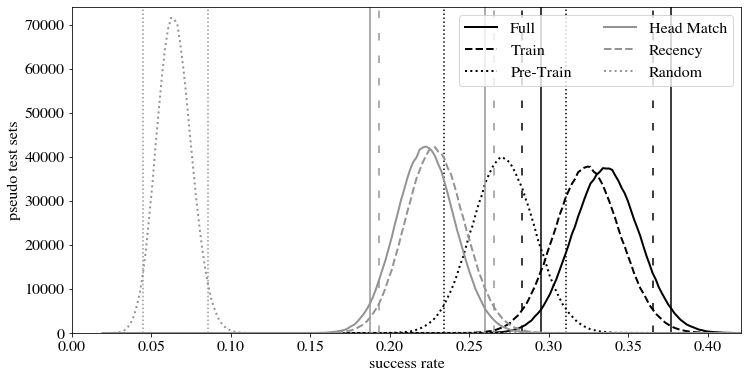

In [408]:
x = []
y = {name:[] for name in sys_names}
for key,values in d_i_count.items():
    x.append(key)
    for name in y.keys():
        y[name].append(values[name])

fig, ax = plt.subplots(1, figsize=(12, 6))

# Draw all the lines in the same plot, assigning a label for each one to be
# shown in the legend.
def sort_this(sort_dict):
    result = []
    
    result.append(("Full", sort_dict["Pre-Train + Train"]))
    result.append(("Train", sort_dict["Train"]))
    result.append(("Pre-Train", sort_dict["Pre-Train"]))
    result.append(("Head Match", sort_dict["Head Match"]))
    result.append(("Recency", sort_dict["Recency"]))
    result.append(("Random", sort_dict["Random"]))
    
    return result

colours = ["-","--",":","-","--",":"]
c_i = 0
further_dict = dict()
for name,values in sort_this(y):
    x_, values = (list(x) for x in zip(*sorted(zip(x, values), key=lambda pair: pair[0])))

    all_vals = []
    max_val = 0
    for x_i, v_i in zip(x_,values):
        if v_i > max_val:
            max_val = v_i
        all_vals+=[x_i]*v_i
    further_dict[name] = all_vals
    lower = all_vals[int(np.floor(len(all_vals)*0.025))]
    mid   = all_vals[int(np.floor(len(all_vals)*0.50))]
    #ax.annotate(name,rotation=45,
            #xy=(mid, max_val), xycoords='data',
            #xytext=(0, 0), textcoords='offset points',
            #arrowprops=dict(facecolor='black', shrink=0.05),
            #horizontalalignment='left', verticalalignment='bottom')
    upper = all_vals[int(np.ceil(len(all_vals)*0.975))]
    print(mid)
    if name in ["Full", "Train", "Pre-Train"]:
        colour = black
    else:
        colour = "xkcd:grey"
    if colours[c_i%len(colours)] == "--":
        ax.axvline(x=lower, linestyle=colours[c_i%len(colours)], color=colour, label='_nolegend_', linewidth=1.5, dashes=(5, 10))
        #ax.axvline(x=mid, linestyle=colours[c_i%len(colours)], color=colour, label='_nolegend_', linewidth=2)
        ax.axvline(x=upper, linestyle=colours[c_i%len(colours)], color=colour, label='_nolegend_', linewidth=1.5, dashes=(5, 10))
    else:
        ax.axvline(x=lower, linestyle=colours[c_i%len(colours)], color=colour, label='_nolegend_', linewidth=1.5)
        #ax.axvline(x=mid, linestyle=colours[c_i%len(colours)], color=colour, label='_nolegend_', linewidth=2)
        ax.axvline(x=upper, linestyle=colours[c_i%len(colours)], color=colour, label='_nolegend_', linewidth=1.5)
    ax.plot(x_, values, colours[c_i%len(colours)], label=name, color=colour, linewidth=2, markerfacecolor="white", markevery=np.argmax(values))
    c_i += 1

# Add a legend, and position it on the lower right (with no box)
plt.legend(loc="upper right", ncol=2)
plt.ylabel('pseudo test sets')
plt.xlabel('success rate')

plt.xlim(0,0.421)
plt.ylim(0,74000)
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

fig, ax = plt.subplots(1, figsize=(12, 6))

data = further_dict.values()

# Multiple box plots on one Axes
ax.boxplot(data, sym="", bootstrap=10)

plt.xticks(range(1,len(further_dict)+1), further_dict.keys())

plt.show()

NameError: name 'further_dict' is not defined

In [750]:
b = 10**6
with open("/proj/zimmermann/ncar/Data/02_ablation_results.pkl", "rb") as f:
    res = pkl.load(f)
    noPOS = res['w/o POS']['Train']
    noEMBED = res['w/o Embeddings']['Train']
    noHEAD = res['w/o Heads']['Train']
    noDIST = res['w/o Distance']['Train']
    noSPAN = res['w/o Spans']['Train']
    noSPANnoHEAD = res['w/o Spans/Heads']['Train']
    noSPANnoDIST = res['w/o Spans/Distance']['Train']
    noSPANnoHEADnoDIST = res['w/o Spans/Heads/Distance']['Train']
    onlyEMBED = res['only Embeddings']['Train']
    onlyPOS = res['only POS']['Train']
#dict_keys(['w/o POS', 'w/o Embeddings', 'w/o Heads', 'w/o Distance', 'w/o Spans',
#'w/o Spans/Heads', 'w/o Spans/Heads/Distance', 'only Embeddings', 'only POS'])

sys_colors = [red, blue, blue, green, green, orange, "xkcd:purple", "xkcd:ugly pink", orange, "black"]
sys_results = [noPOS,noEMBED,noHEAD,noDIST,noSPAN,noSPANnoHEAD,noSPANnoDIST,noSPANnoHEADnoDIST,onlyEMBED,onlyPOS, TRAIN]
sys_names = ['w/o POS', 'w/o Embeddings', 'w/o Heads', 'w/o Distance', 'w/o Spans',
             'w/o Spans/Heads', 'w/o Spans/Distance', 'w/o Spans/Heads/Distance', 'only Embeddings', 'only POS', 'TRAIN']
x = list(zip(*sys_results))
for i in range(len(sys_results)):
    for j in range(len(sys_results)):
        if i != j and i == len(sys_results)-1 or j == len(sys_results)-1:
            
            sum_i = sum([r[i] for r in x])
            sum_j = sum([r[j] for r in x])
                
            d_i = sum_i/len(x)
            d_j = sum_j/len(x)
            d = abs(d_i - d_j)
            print()
            s = 0
            for _ in range(b):
                
                x_ = rnd.choices(x, k=512)
                
                sum_i = sum([r[i] for r in x_])
                sum_j = sum([r[j] for r in x_])
                
                d_ = abs(sum_i/len(x_) - sum_j/len(x_))
            
                if d_ > 2*d:
                    s += 1
                    
            print(f"{sys_names[i]} ({d_i}) to {sys_names[j]} ({d_j}), p-value: {s/b}")


w/o POS (0.298828125) to TRAIN (0.2890625), p-value: 0.33397

w/o Embeddings (0.271484375) to TRAIN (0.2890625), p-value: 0.23058

w/o Heads (0.279296875) to TRAIN (0.2890625), p-value: 0.33056

w/o Distance (0.3359375) to TRAIN (0.2890625), p-value: 0.0039

w/o Spans (0.3359375) to TRAIN (0.2890625), p-value: 0.00912

w/o Spans/Heads (0.248046875) to TRAIN (0.2890625), p-value: 0.02178

w/o Spans/Distance (0.341796875) to TRAIN (0.2890625), p-value: 0.00455

w/o Spans/Heads/Distance (0.26953125) to TRAIN (0.2890625), p-value: 0.15857

only Embeddings (0.22265625) to TRAIN (0.2890625), p-value: 0.00088

only POS (0.25) to TRAIN (0.2890625), p-value: 0.04095

TRAIN (0.2890625) to w/o POS (0.298828125), p-value: 0.331

TRAIN (0.2890625) to w/o Embeddings (0.271484375), p-value: 0.23079

TRAIN (0.2890625) to w/o Heads (0.279296875), p-value: 0.33466

TRAIN (0.2890625) to w/o Distance (0.3359375), p-value: 0.0044

TRAIN (0.2890625) to w/o Spans (0.3359375), p-value: 0.00913

TRAIN (0.2890

In [668]:
antecedents = 0
domains = {}
for sample in combined_folds:
    antecedents += sample[2].count(2)
    domain = sample[-1].split("_")[0]
    if domain in domains:
        domains[domain].append(len(sample[0]))
    else:
        domains[domain] = [len(sample[0])]

for key,value in domains.items():
    print(key, np.mean(value))

ectb 53.15686274509804
wsj 53.69832402234637
nt 28.22463768115942
nbc 42.0
cnn 39.07142857142857
a2e 51.95
pri 53.22222222222222
ch 19.857142857142858
c2e 39.2
chtb 70.78571428571429
eng 44.303030303030305
voa 70.4
cctv 48.166666666666664
mnb 57.0
msnbc 39.857142857142854


In [532]:
print(512/antecedents)

0.08998242530755712


In [695]:
with open("/proj/zimmermann/ncar/Data/02_ablation_results.pkl", "rb") as f:
    ablation_results = pkl.load(f)
print(ablation_results.keys())
print([sum(x["Train"])/512 for x in ablation_results.values()])

dict_keys(['w/o POS', 'w/o Embeddings', 'w/o Heads', 'w/o Distance', 'w/o Spans', 'w/o Spans/Heads', 'w/o Spans/Heads/Distance', 'only Embeddings', 'only POS'])
[0.298828125, 0.271484375, 0.279296875, 0.3359375, 0.3359375, 0.248046875, 0.26953125, 0.22265625, 0.25]


l 45.146484375
coref l 50.16679738562092
Counter()
d 14.158203125
c 11.11328125
cd 3.654296875
coref d 20.05673202614379
coref c 12.772287581699347
cd 5.501176470588235


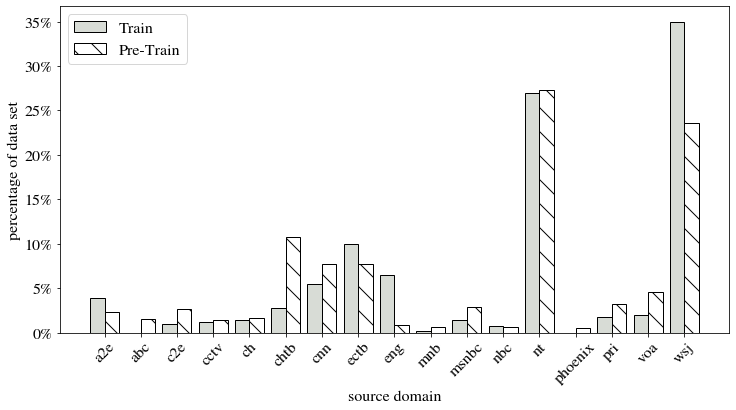

In [82]:
from collections import Counter

lens = []
docs = []
for sample in combined_folds:
    lens.append(len(sample[0]))
    docs.append(sample[-1])
print("l", np.mean(lens))

lens = []
new_coref = []
trash = []
for sample in combined_coref:
    if sample[-1] not in docs:
        new_coref.append(sample)
        lens.append(len(sample[0]))
    else:
        trash.append(sample[-1].split("_")[0])
print("coref l", np.mean(lens))
combined_coref=new_coref

print(Counter(trash))


dists = []
candidates = []
cand_dists = []
ds = []
for sample in combined_folds:
    s = sample 
    d = s[-1].split("_")[0]
    ds.append(d)
    h = np.argmax(s[2])
        
    p = [i2p[s_i] for s_i in s[-2]]
    y = np.argmax(s[4])
    dists.append(abs(y-h))
    cand_dists.append(s[2][min(y,h):max(y,h)].count(2))
    candidates.append(s[2].count(2))
    t = [i2w[ii] if i != y else f"[{i2w[ii]}]"  for i,ii in enumerate(s[0])]
    
    h_id = s[3][0][h]
    anaphora = [t_i for t_i,m_i in zip(t,s[3][0]) if m_i == h_id]
print("d", np.mean(dists))
print("c", np.mean(candidates))
print("cd", np.mean(cand_dists))
Ci = Counter(ds)

dists = []
candidates = []
mods = {}
cand_dists = []
ds = []
for sample in combined_coref:
    s = sample 
    
    d = s[-1].split("_")[0]
    ds.append(d)
        
    h = np.argmax(s[2])
        
    p = [i2p[s_i] for s_i in s[-2]]
    y = np.argmax(s[4])
    dists.append(abs(y-h))
    cand_dists.append(s[2][min(y,h):max(y,h)].count(2))
    candidates.append(s[2].count(2))
    t = [i2w[ii] if i != y else f"[{i2w[ii]}]"  for i,ii in enumerate(s[0])]
    
        
    h_id = s[3][0][h]
    anaphora = [t_i for t_i,m_i in zip(t,s[3][0]) if m_i == h_id]
Cj = Counter(ds)

print("coref d", np.mean(dists))
print("coref c", np.mean(candidates))
print("cd", np.mean(cand_dists))

keys = set()
for key in Ci.keys():
    keys.add(key)
    if key not in Cj:
        Cj[key]=0

for key in Cj.keys():
    keys.add(key)
    if key not in Ci:
        Ci[key]=0

Ci = sorted(Ci.items())
keys = sorted(keys)
Cj = sorted(Cj.items()) 
bar_width= 0.4
fig, ax = plt.subplots(1, figsize=(12, 6))

patterns = [ "|" , "\\" , "/" , "+" , "-", ".", "*","x", "o", "O" ]

plt.bar([v-bar_width for v in range(len(Ci))], [v[1]/512 for v in Ci], width=bar_width, align='edge', edgecolor='black', color="xkcd:light grey")
plt.xticks(range(len(Ci)), keys, rotation=45)


plt.bar(range(len(Cj)), [v[1]/3825 for v in Cj], width=bar_width, align='edge', edgecolor='black', color="xkcd:white", hatch=patterns[1])


plt.xlabel('source domain')
plt.ylabel('percentage of data set')
#plt.xticks(index + bar_width, (Ci+Cj).keys())
plt.legend(['Train', 'Pre-Train'])
#ax.set_yscale('log',basey=2)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
#plt.tight_layout()
plt.show()